Bulk objects inspection; apply GAIA->LS filter transformation

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    # plt.grid(alpha=0.5, lw=0.5)
    return ax

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_center, bin_median, bin_spread = np.zeros((3, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.median(x[mask])
        if np.sum(mask)>0:
            bin_median[index] = np.median(y[mask])
            bin_spread[index] = nmad(y[mask])
        else:
            bin_median[index], bin_spread[index] = np.nan, np.nan
    return bin_center, bin_median, bin_spread

-------

In [20]:
# gaia1 and gaia2: DECaLS/DES SGC; gaia3: BASS/MzLS; gaia4: DECaLS NGC
gaia_fn = 'gaia3.fits.gz'
field = 'north'
gaia = Table.read('/Users/rongpu/Documents/Data/desi_misc/gaia_from_arjun/'+gaia_fn)
print(len(gaia))

if (gaia_fn=='gaia1.fits.gz') or (gaia_fn=='gaia2.fits.gz'):
    mask = gaia['dec']<31.
    gaia = gaia[mask]
    print(len(gaia))
                                  
if (gaia_fn=='gaia3.fits.gz'):
    mask = gaia['dec']>32.375
    gaia = gaia[mask]
    print(len(gaia))

568011
495651


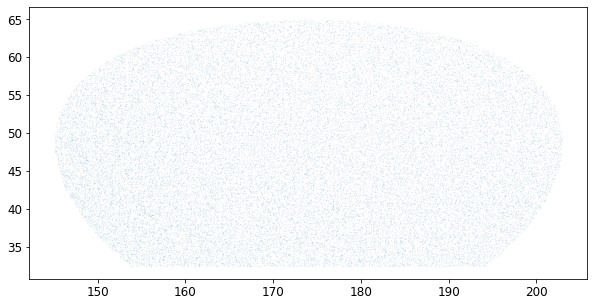

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(gaia['ra'][::10], gaia['dec'][::10], '.', ms=0.1, alpha=0.5)
plt.show()

In [22]:
# Remove duplicates
if len(np.unique(gaia['source_id']))<len(gaia):
    print('Duplicates exist!')
    gaia.sort('source_id')
    mask = gaia['source_id'][1:]==gaia['source_id'][:-1]
    mask = np.concatenate([[False], mask])
    gaia = gaia[~mask]
    
# Remove objects with invalide mask = np.isfinite(gaia['bp_rp'])
mask = np.isfinite(gaia['bp_rp'])
if np.sum(~mask)>0:
    print('{} objects with invalid bp_rp'.format(np.sum(~mask)))
    gaia = gaia[mask]

5136 objects with invalid bp_rp


In [23]:
# Apply GAIA-LS transformation
from scipy.interpolate import interp1d
transform_interp = {}
for band in ['g', 'r', 'z']:
    tmp = np.load('data/gaia_bassmzls_{}_transform.npz'.format(band))
    bin_center, bin_median, bin_spread = tmp['arr_0'], tmp['arr_1'], tmp['arr_2']
    transform_interp[band] = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')
    gaia['ls_'+band] = gaia['phot_g_mean_mag'] + transform_interp[band](gaia['bp_rp'])

-----

In [25]:
band = 'g'

plot_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/plots/03/'
download_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/cutouts/'
# img_type = '-resid'
img_type = ''
if (field=='north') and ((band=='g') or (band=='r')):
    pixscale_str = '0.455'
else:
    pixscale_str = '0.262'
pixscale = float(pixscale_str)
size_str = '512'

# narrow bins of LS magnitude
ls_mag_min_list = [10.5, 13.0, 15.5]
ls_mag_max_list = [10.51, 13.01, 15.51]
nsamp = 5

In [27]:
radius_in_bin = []
flux_in_bin = []

for mag_index in range(len(ls_mag_min_list)):

    ls_mag_min, ls_mag_max = ls_mag_min_list[mag_index], ls_mag_max_list[mag_index]
    print('{} < {} < {}'.format(ls_mag_min, band, ls_mag_max))

    idx = np.where((gaia['ls_'+band]>ls_mag_min) & (gaia['ls_'+band]<ls_mag_max))[0]
    print(len(idx))
    if len(idx)>nsamp:
        np.random.seed(1)
        idx = np.random.choice(idx, size=nsamp, replace=False)
        # print(len(idx))

    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
    radius_arr = []
    flux_arr = []

    for index in idx:

        print('phot_g_mean_mag = ', gaia['phot_g_mean_mag'][index])

        ra, dec = gaia['ra'][index], gaia['dec'][index]

        file_path = os.path.join(download_dir, gaia_fn[:-8], '{}_{}{}_{}_{}.fits'.format(gaia['source_id'][index], band, img_type, pixscale_str, size_str))
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))

        if not os.path.isfile(file_path):
            url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8{}&pixscale={}&bands={}&size={}'.format(ra, dec, img_type, pixscale_str, band, size_str)
            cmd = 'wget -O '+file_path+' \"'+url+'\"'
            print(cmd)
            os.system(cmd)

        img_raw = fitsio.read(file_path)
        img = img_raw / (pixscale**2)

        grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
        xx, yy = np.meshgrid(grid, grid)
        radius = np.sqrt(xx**2 + yy**2).flatten()
        max_radius = xx.flatten().max() # maximum radius before hitting the edge of the image

        # Remove masked pixels
        mask = img.flatten()!=0
        radius = radius[mask]
        flux = img.flatten()[mask]

        bin_center, bin_median, bin_spread = binned_stats(radius, flux, bins=np.linspace(0., np.floor(max_radius), int(np.floor(max_radius)+1)))
        radius_arr.append(bin_center)
        flux_arr.append(bin_median)

    radius_arr = np.array(radius_arr)
    flux_arr = np.array(flux_arr)
    
    x, y, _ = binned_stats(radius_arr.flatten(), flux_arr.flatten(), bins=np.linspace(0., np.floor(max_radius), int(np.floor(max_radius)+1)))
    radius_in_bin.append(x)
    flux_in_bin.append(y)
    
    print()

10.5 < g < 10.51
43
phot_g_mean_mag =  10.2959175
phot_g_mean_mag =  9.926793
phot_g_mean_mag =  10.249126
phot_g_mean_mag =  9.959888
phot_g_mean_mag =  10.246129

13.0 < g < 13.01
300
phot_g_mean_mag =  12.654937
phot_g_mean_mag =  12.50844
phot_g_mean_mag =  12.811268
phot_g_mean_mag =  12.761594
phot_g_mean_mag =  12.548194

15.5 < g < 15.51
930
phot_g_mean_mag =  15.165641
phot_g_mean_mag =  14.928203
phot_g_mean_mag =  14.985726
phot_g_mean_mag =  14.655326
phot_g_mean_mag =  14.847236



In [28]:
# t = Table()
# t['radius'] = radius_in_bin[0]
# for index in range(len(flux_in_bin)):
#     t['flux_{}_{:.2f}'.format(band, ls_mag_min_list[index])] = flux_in_bin[index]
# mask = t['radius']>=95.5
# t = t[~mask]

# t.write('data/BASSMZLS_profiles_{}.txt'.format(band), format='ascii.commented_header')

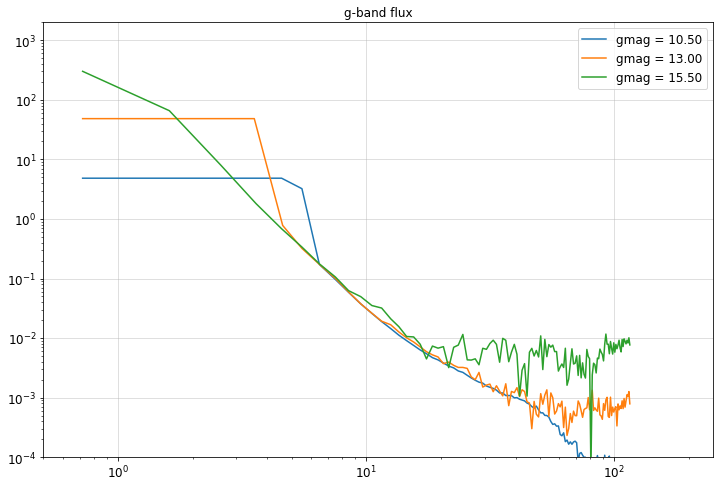

In [29]:
plt.figure(figsize=(12, 8))
for index in range(len(flux_in_bin)):
    # normalize the flux to 13th magnitude stars
    norm = 10**((ls_mag_min_list[index]-13)/2.5)
    plt.loglog(radius_in_bin[index], flux_in_bin[index]*norm, lw=1.5, alpha=1., 
               label='{}mag = {:.2f}'.format(band, ls_mag_min_list[index]))
plt.title('{}-band flux'.format(band))

plt.axis([.5, 250, .0001, 2000])
plt.grid(alpha=0.5)
plt.legend()
plt.show()

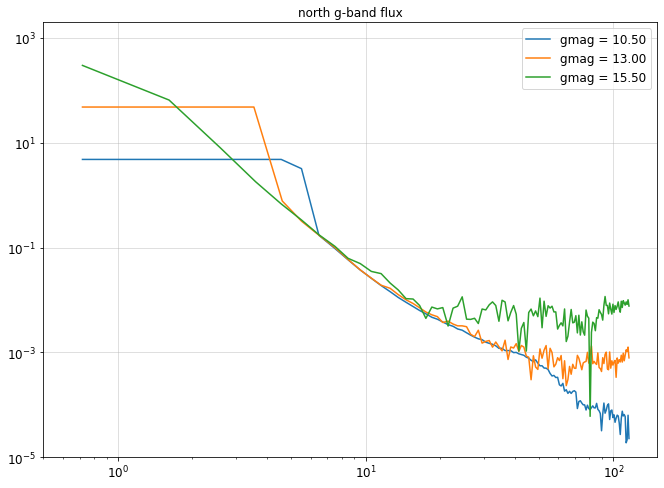

In [42]:
plt.figure(figsize=(11, 8))
for index in range(len(flux_in_bin)):
    # normalize the flux to 13th magnitude stars
    norm = 10**((ls_mag_min_list[index]-13)/2.5)
    plt.loglog(radius_in_bin[index], flux_in_bin[index]*norm, lw=1.5, alpha=1., 
               label='{}mag = {:.2f}'.format(band, ls_mag_min_list[index]))
plt.title('{} {}-band flux'.format(field, band))

plt.axis([.5, 150, .00001, 2000])
plt.grid(alpha=0.5)
plt.legend()
plt.show()